# Something 1

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from cplex import Cplex
import cplex
from cplex.exceptions import CplexError
import numpy as np
import math


## Auxiliary Functions

In [2]:
def read_instance(filename):
    """
    Reads the CVRP instance from a file.

    The file format is assumed to be:
    - The first line contains two numbers: number of customers and best known solution (ignored).
    - The second line contains the vehicle capacity.
    - The third line contains the depot coordinates (x y).
    - The following lines contain customer data: customer number, x, y, demand.

    Returns:
    - capacity: Vehicle capacity.
    - depot_coords: Coordinates of the depot (tuple).
    - customers: List of customer dictionaries with keys 'number', 'x', 'y', 'demand'.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Remove any empty lines or lines with only whitespace
    lines = [line.strip() for line in lines if line.strip()]

    idx = 0
    num_customers, _ = map(float, lines[idx].split())
    num_customers = int(num_customers)
    idx += 1
    capacity = int(lines[idx])
    idx += 1
    depot_coords = tuple(map(int, lines[idx].split()))
    idx += 1

    customers = []
    for _ in range(num_customers):
        customer_info = lines[idx].split()
        idx += 1
        customer_number = int(customer_info[0])
        x = int(customer_info[1])
        y = int(customer_info[2])
        demand = int(customer_info[3])
        customers.append({
            'number': customer_number,
            'x': x,
            'y': y,
            'demand': demand
        })

    return capacity, depot_coords, customers

In [3]:
def read_cvrplib_instance(file_path):
    """
    Reads a CVRP instance from a CVRPLIB file and returns the node coordinates, demands, and capacity.
    """
    node_coords = {}
    customers = []
    depot_coords = tuple()
    capacity = 0
    with open(file_path, 'r') as file:
        section = None
        for line in file:
            line = line.strip()
            if line.startswith('CAPACITY'):
                capacity = int(line.split(':')[1].strip())
            elif line.startswith('NODE_COORD_SECTION'):
                section = 'NODE_COORD_SECTION'
            elif line.startswith('DEMAND_SECTION'):
                section = 'DEMAND_SECTION'
            elif line.startswith('DEPOT_SECTION'):
                break
            elif section == 'NODE_COORD_SECTION' and line != '':
                parts = line.split()

                node_id = int(parts[0])
                x_coord = int(parts[1])
                y_coord = int(parts[2])

                if node_id == 0:
                    depot_coords = (x_coord, y_coord)
                else:
                    customers.append({
                        'number': node_id,
                        'x': x_coord,
                        'y': y_coord,
                        'demand': 0
                    })
                    # print(customers)
            elif section == 'DEMAND_SECTION' and line != '':
                parts = line.split()

                node_id = int(parts[0])
                demand = float(parts[1])

                if node_id != 0:
                    customers[node_id-1]['demand'] = demand
    return capacity, depot_coords, customers

In [4]:
def compute_distance_matrix(coords, euc2d: bool=False):
    """
    Computes the Manhatan distance matrix between all pairs of coordinates.

    Args:
    - coords: List of (x, y) tuples.

    Returns:
    - distance_matrix: 2D list of distances between nodes.
    """
    num_nodes = len(coords)
    distance_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    for i in range(num_nodes):
        xi, yi = coords[i]
        for j in range(num_nodes):
            xj, yj = coords[j]
            if euc2d:
                # Euclidean Distance
                distance = math.hypot(xi - xj, yi - yj)
            else:
                # Manhattan Distance
                distance = abs(xi - xj) + abs(yi - yj)
            distance_matrix[i][j] = int(distance)
    return distance_matrix

## Geração de Coluna

### Based on Tutorial on Column Generation

In [5]:
def build_sub_graph(node_indices, distance_matrix):
    """Build the graph for the subproblems"""
    G_sub = nx.DiGraph()
    for i in node_indices:
        for j in node_indices:
            if i != j:
                G_sub.add_edge(i, j, cost=distance_matrix[i][j])
    return G_sub

In [6]:
def solve_cvrp_column_generation(filename : str, cvrplib: bool = False):
    """
    """
    # Read instance data
    if cvrplib:
        capacity, depot_coords, customers = read_cvrplib_instance(filename)
    else:
        capacity, depot_coords, customers = read_instance(filename)
    num_customers = len(customers)
    num_nodes = num_customers + 1  # Including depot (node 0)
    customer_indices = list(range(1, num_nodes))
    node_indices = list(range(num_nodes))

    # Coordinates for depot and customers
    coords = [depot_coords] + [(c['x'], c['y']) for c in customers]
    demands = [0] + [c['demand'] for c in customers]
    distance_matrix = compute_distance_matrix(coords)

    # Build the graph for the subproblem
    G_sub = build_sub_graph(node_indices, distance_matrix)

    # Initialize columns (routes)
    # Start with simple routes, e.g., one customer per route
    routes = []
    for i in customer_indices:
        route = [0, i, 0]
        cost = distance_matrix[0][i] + distance_matrix[i][0]
        routes.append({
            'route': route,
            'cost': cost,
            'demands': demands[i],
            'a': [1 if j == i else 0 for j in customer_indices]
        })

    # Column generation process
    MAX_ITER = 1000
    iteration = 0
    epsilon = 1e-6

    while True:
        iteration += 1
        print(f"\nIteration {iteration}")

        # Build and solve the master problem
        master_prob = Cplex()
        master_prob.set_log_stream(None)
        master_prob.set_error_stream(None)
        master_prob.set_warning_stream(None)
        master_prob.set_results_stream(None)
        master_prob.parameters.timelimit.set(1800)
        master_prob.objective.set_sense(master_prob.objective.sense.minimize)

        # Add variables (columns)
        num_routes = len(routes)
        var_names = [f'x_{k}' for k in range(num_routes)]
        obj = [r['cost'] for r in routes]
        lb = [0] * num_routes
        ub = [1] * num_routes  # Variables are continuous between 0 and 1
        x = master_prob.variables.add(obj=obj, lb=lb, ub=ub, names=var_names)

        # Add constraints: each customer must be visited at least once
        rows = []
        for i in range(len(customer_indices)):
            a_i = [routes[k]['a'][i] for k in range(num_routes)]
            rows.append([var_names, a_i])

        rhs = [1] * len(customer_indices)
        senses = ['G'] * len(customer_indices)  # Change to 'G' for >= constraints
        row_names = [f'c_{i+1}' for i in range(len(customer_indices))]
        master_prob.linear_constraints.add(lin_expr=rows, senses=senses, rhs=rhs, names=row_names)

        # Add fleet size constraint
        total_vehicles = len(routes)
        vehicle_row = [[var_names, [1]*num_routes]]
        master_prob.linear_constraints.add(lin_expr=vehicle_row, senses=['L'], rhs=[total_vehicles])

        # Solve the master problem
        try:
            master_prob.solve()
        except CplexError as e:
            print("Error solving master problem:", e)
            return

        # Get the dual prices
        pi = master_prob.solution.get_dual_values()
        lambda_i = pi[:-1]  # Dual variables for customer constraints
        lambda_0 = pi[-1]   # Dual variable for fleet size constraint

        # Solve the pricing subproblem (ESPPRC)
        # Adjust arc costs using dual variables
        adjusted_costs = {}
        for i in node_indices:
            for j in node_indices:
                if i != j:
                    adjusted_cost = distance_matrix[i][j]
                    if j != 0:
                        # Subtract the dual variable associated with customer j
                        adjusted_cost -= lambda_i[j - 1]
                    if i == 0:
                        # Subtract the fleet size dual variable when departing from the depot
                        adjusted_cost -= lambda_0
                    adjusted_costs[(i, j)] = adjusted_cost

        # Implement a labeling algorithm for ESPPRC
        labels = []
        # Label format: (current_node, cumulative_cost, cumulative_demand, path, visited)
        initial_label = (0, 0, 0, [0], set([0]))
        labels.append(initial_label)
        
        # Flag to indicate if a negative reduced cost route is found
        found_negative_route = False
        new_route = None
        
        while labels and not found_negative_route:
            current_label = labels.pop()
            current_node, cum_cost, cum_demand, path, visited = current_label

            # Extend the path
            for next_node in customer_indices + [0]:
                if next_node in visited and next_node != 0:
                    continue  # Avoid cycles

                demand = demands[next_node]
                new_cum_demand = cum_demand + demand
                if new_cum_demand > capacity:
                    continue  # Exceed capacity

                arc = (current_node, next_node)
                if arc not in adjusted_costs:
                    continue

                new_cum_cost = cum_cost + adjusted_costs[arc]
                new_path = path + [next_node]
                new_visited = visited.copy()
                new_visited.add(next_node)

                if next_node == 0 and len(new_path) > 2:
                    # Complete route back to depot
                    if new_cum_cost < -epsilon:
                        # Negative reduced cost route found
                        actual_cost = sum(distance_matrix[new_path[i]][new_path[i+1]] for i in range(len(new_path)-1))
                        a_k = [1 if idx+1 in new_path else 0 for idx in range(len(customer_indices))]
                        new_route = {
                            'route': new_path,
                            'cost': actual_cost,
                            'demands': new_cum_demand,
                            'a': a_k
                        }
                        found_negative_route = True
                        break  # Exit the while loop
                else:
                    labels.append((next_node, new_cum_cost, new_cum_demand, new_path, new_visited))

        # Check if we have a new route with negative reduced cost
        if new_route:
            print(f"Found new route with negative reduced cost: {new_route['route']}")
            routes.append(new_route)
        else:
            print("No more routes with negative reduced cost.")
            break

        if iteration >= MAX_ITER:
            print("Reached maximum number of iterations.")
            break

    # Retrieve the solution from the master problem
    solution_values = master_prob.solution.get_values()
    selected_routes = [routes[i] for i in range(len(routes)) if solution_values[i] > epsilon]

    print("\nOptimal solution:")
    total_cost = 0
    for idx, r in enumerate(selected_routes):
        print(f"Route {idx + 1}: {r['route']}, Cost: {r['cost']:.2f}")
        total_cost += r['cost']
    print(f"Total cost: {total_cost:.2f}")
    print(selected_routes)
    # Visualize the solution
    visualize_routes(coords, selected_routes)

def visualize_routes(coords, routes):
    import matplotlib.pyplot as plt
    import networkx as nx

    G = nx.DiGraph()

    # Add nodes
    for idx, (x, y) in enumerate(coords):
        if idx == 0:
            G.add_node(idx, pos=(x, y), label='Depot')
        else:
            G.add_node(idx, pos=(x, y), label=f'C-{idx}')

    # Define colors for different routes
    num_routes = len(routes)
    color_map = plt.cm.get_cmap('tab20', num_routes)

    # Add edges for each route
    edge_list = []
    edge_colors = []
    for idx, route_info in enumerate(routes):
        route = route_info['route']
        color = color_map(idx)
        for i in range(len(route) - 1):
            u = route[i]
            v = route[i + 1]
            edge_list.append((u, v))
            edge_colors.append(color)

    # Add edges to the graph
    G.add_edges_from(edge_list)

    # Get positions and labels
    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_node_attributes(G, 'label')

    # Draw nodes
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')

    # Draw node labels
    nx.draw_networkx_labels(G, pos, labels, font_size=12)

    # Draw edges
    nx.draw_networkx_edges(
        G, pos,
        edgelist=edge_list,
        edge_color=edge_colors,
        arrows=True,
        width=2,
        arrowstyle='-|>',
        arrowsize=15
    )

    plt.title('CVRP Solution Visualization', fontsize=16)
    plt.axis('equal')
    plt.show()

    



Iteration 1
Found new route with negative reduced cost: [0, 10, 9, 0]

Iteration 2
Found new route with negative reduced cost: [0, 10, 9, 0]

Iteration 3
Found new route with negative reduced cost: [0, 10, 7, 0]

Iteration 4
Found new route with negative reduced cost: [0, 9, 8, 0]

Iteration 5
Found new route with negative reduced cost: [0, 9, 8, 7, 0]

Iteration 6
Found new route with negative reduced cost: [0, 9, 8, 6, 0]

Iteration 7
Found new route with negative reduced cost: [0, 9, 7, 6, 0]

Iteration 8
Found new route with negative reduced cost: [0, 9, 7, 6, 5, 0]

Iteration 9
Found new route with negative reduced cost: [0, 9, 7, 6, 5, 4, 0]

Iteration 10
Found new route with negative reduced cost: [0, 9, 7, 6, 4, 1, 0]

Iteration 11
Found new route with negative reduced cost: [0, 9, 6, 7, 0]

Iteration 12
Found new route with negative reduced cost: [0, 9, 6, 7, 5, 0]

Iteration 13
Found new route with negative reduced cost: [0, 9, 6, 7, 5, 4, 0]

Iteration 14
Found new route wi

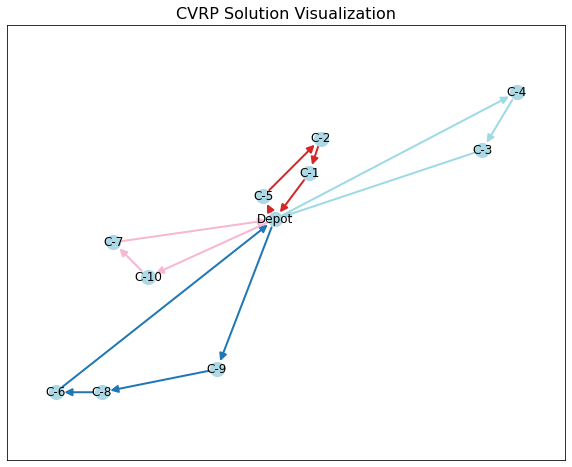

In [8]:
filename =  '../Instances/simple.txt' # '../Instances/simple.txt'
solve_cvrp_column_generation(filename, cvrplib=False)

### Improvements over base Column Generation

#### Heuristic for Pricing Subproblem

In [13]:
def heuristic_pricing_subproblem(customer_indices, node_indices, demands, capacity, distance_matrix, lambda_i, lambda_0):
    epsilon = 1e-6

    # Compute adjusted costs
    adjusted_costs = {}
    for i in node_indices:
        for j in node_indices:
            if i != j:
                adjusted_cost = distance_matrix[i][j]
                if j != 0:
                    adjusted_cost -= lambda_i[j - 1]
                if i == 0:
                    adjusted_cost -= lambda_0
                adjusted_costs[(i, j)] = adjusted_cost

    # Compute adjusted savings
    savings_list = []
    for i in customer_indices:
        for j in customer_indices:
            if i < j:
                s_0i = adjusted_costs[(0, i)]
                s_0j = adjusted_costs[(0, j)]
                s_ij = adjusted_costs.get((i, j), float('inf'))
                s_ji = adjusted_costs.get((j, i), float('inf'))
                savings = s_0i + s_0j - min(s_ij, s_ji)
                savings_list.append((savings, i, j))

    # Sort savings in decreasing order
    savings_list.sort(reverse=True)

    # Initialize routes: one per customer
    routes = {i: [0, i, 0] for i in customer_indices}
    route_demands = {i: demands[i] for i in customer_indices}

    # Merge routes based on savings
    for savings, i, j in savings_list:
        # Find the routes containing i and j
        route_i = None
        route_j = None
        for route_id, route in routes.items():
            if route[1] == i:
                route_i = route
            if route[1] == j:
                route_j = route
            if route_i and route_j:
                break

        if route_i is None or route_j is None or route_i == route_j:
            continue  # Already in the same route or route not found

        # Check if merging the routes exceeds capacity
        total_demand = route_demands[route_i[1]] + route_demands[route_j[1]]
        if total_demand > capacity:
            continue

        # Merge routes
        merged_route = [0] + route_i[1:-1] + route_j[1:-1] + [0]
        routes[route_i[1]] = merged_route
        route_demands[route_i[1]] = total_demand
        # Remove the old route
        del routes[route_j[1]]
        del route_demands[route_j[1]]

    # Create list of routes
    new_routes = []
    for route in routes.values():
        # Calculate reduced cost of the route
        reduced_cost = 0
        for k in range(len(route) - 1):
            i = route[k]
            j = route[k + 1]
            reduced_cost += adjusted_costs[(i, j)]
        if reduced_cost < -epsilon:
            actual_cost = sum(distance_matrix[route[i]][route[i+1]] for i in range(len(route)-1))
            a_k = [1 if idx in route else 0 for idx in customer_indices]
            new_route = {
                'route': route,
                'cost': actual_cost,
                'demands': sum(demands[node] for node in route if node != 0),
                'a': a_k
            }
            new_routes.append(new_route)

    return new_routes

In [14]:
def exact_pricing_subproblem(customer_indices, node_indices, demands, capacity, distance_matrix, lambda_i, lambda_0):
    """
    Exact pricing subproblem using labeling algorithm (ESPPRC).
    """
    epsilon = 1e-6

    # Adjust arc costs using dual variables
    adjusted_costs = {}
    for i in node_indices:
        for j in node_indices:
            if i != j:
                adjusted_cost = distance_matrix[i][j]
                if j != 0:
                    # Subtract the dual variable associated with customer j
                    adjusted_cost -= lambda_i[j - 1]
                if i == 0:
                    # Subtract the fleet size dual variable when departing from the depot
                    adjusted_cost -= lambda_0
                adjusted_costs[(i, j)] = adjusted_cost

    # Implement a labeling algorithm for ESPPRC
    labels = []
    # Label format: (current_node, cumulative_cost, cumulative_demand, path, visited)
    initial_label = (0, 0, 0, [0], set([0]))
    labels.append(initial_label)

    # Store all routes with negative reduced cost
    negative_routes = []
    # Set a limit on the number of routes to collect
    MAX_ROUTES_PER_ITERATION = 10

    while labels:
        current_label = labels.pop()
        current_node, cum_cost, cum_demand, path, visited = current_label

        # Extend the path
        for next_node in customer_indices + [0]:
            if next_node in visited and next_node != 0:
                continue  # Avoid cycles

            demand = demands[next_node]
            new_cum_demand = cum_demand + demand
            if new_cum_demand > capacity:
                continue  # Exceed capacity

            arc = (current_node, next_node)
            if arc not in adjusted_costs:
                continue

            new_cum_cost = cum_cost + adjusted_costs[arc]
            new_path = path + [next_node]
            new_visited = visited.copy()
            new_visited.add(next_node)

            if next_node == 0 and len(new_path) > 2:
                # Complete route back to depot
                if new_cum_cost < -epsilon:
                    # Negative reduced cost route found
                    actual_cost = sum(distance_matrix[new_path[i]][new_path[i+1]] for i in range(len(new_path)-1))
                    a_k = [1 if idx in new_path else 0 for idx in customer_indices]
                    new_route = {
                        'route': new_path,
                        'cost': actual_cost,
                        'demands': new_cum_demand,
                        'a': a_k
                    }
                    negative_routes.append(new_route)
                    # Check if we have reached the maximum number of routes
                    if len(negative_routes) >= MAX_ROUTES_PER_ITERATION:
                        break  # Exit the for loop
            else:
                labels.append((next_node, new_cum_cost, new_cum_demand, new_path, new_visited))
        else:
            continue  # Continue if the inner loop wasn't broken
        break  # Break out of the while loop if inner loop was broken

    return negative_routes

#### Improved Column Generation

In [19]:
def solve_cvrp_column_generation(filename : str, cvrplib: bool=False):
    """
    """
    # Read instance data
    if cvrplib:
        capacity, depot_coords, customers = read_cvrplib_instance(filename)
    else:
        capacity, depot_coords, customers = read_instance(filename)
    num_customers = len(customers)
    num_nodes = num_customers + 1  # Including depot (node 0)
    customer_indices = list(range(1, num_nodes))
    node_indices = list(range(num_nodes))

    # Coordinates for depot and customers
    coords = [depot_coords] + [(c['x'], c['y']) for c in customers]
    demands = [0] + [c['demand'] for c in customers]
    distance_matrix = compute_distance_matrix(coords)

    # Build the graph for the subproblem
    G_sub = build_sub_graph(node_indices, distance_matrix)

    # Initialize columns (routes)
    # Start with simple routes, e.g., one customer per route
    routes = []
    for i in customer_indices:
        route = [0, i, 0]
        cost = distance_matrix[0][i] + distance_matrix[i][0]
        routes.append({
            'route': route,
            'cost': cost,
            'demands': demands[i],
            'a': [1 if j == i else 0 for j in customer_indices]
        })

    # Column generation process
    MAX_ITER = 30
    iteration = 0
    epsilon = 1e-6

    while True:
        iteration += 1
        print(f"\nIteration {iteration}")

        # Build and solve the master problem
        master_prob = Cplex()
        master_prob.set_log_stream(None)
        master_prob.set_error_stream(None)
        master_prob.set_warning_stream(None)
        master_prob.set_results_stream(None)
        master_prob.parameters.timelimit.set(1800)
        master_prob.objective.set_sense(master_prob.objective.sense.minimize)

        # Add variables (columns)
        num_routes = len(routes)
        var_names = [f'x_{k}' for k in range(num_routes)]
        obj = [r['cost'] for r in routes]
        lb = [0] * num_routes
        ub = [1] * num_routes  # Variables are continuous between 0 and 1
        x = master_prob.variables.add(obj=obj, lb=lb, ub=ub, names=var_names)

        # Add constraints: each customer must be visited at least once
        rows = []
        for i in range(len(customer_indices)):
            a_i = [routes[k]['a'][i] for k in range(num_routes)]
            rows.append([var_names, a_i])

        rhs = [1] * len(customer_indices)
        senses = ['G'] * len(customer_indices)  # Change to 'G' for >= constraints
        row_names = [f'c_{i+1}' for i in range(len(customer_indices))]
        master_prob.linear_constraints.add(lin_expr=rows, senses=senses, rhs=rhs, names=row_names)

        # Add fleet size constraint
        total_vehicles = len(routes)
        vehicle_row = [[var_names, [1]*num_routes]]
        master_prob.linear_constraints.add(lin_expr=vehicle_row, senses=['L'], rhs=[total_vehicles])

        # Solve the master problem
        try:
            master_prob.solve()
        except CplexError as e:
            print("Error solving master problem:", e)
            return

        # Get the dual prices
        pi = master_prob.solution.get_dual_values()
        lambda_i = pi[:-1]  # Dual variables for customer constraints
        lambda_0 = pi[-1]   # Dual variable for fleet size constraint

        # Call the heuristic pricing subproblem
        heuristic_routes = heuristic_pricing_subproblem(customer_indices, node_indices, demands, capacity, distance_matrix, lambda_i, lambda_0)
        if heuristic_routes:
            print(f"Found {len(heuristic_routes)} new routes with negative reduced cost using heuristic.")
            routes.extend(heuristic_routes)
        else:
            print("No more routes with negative reduced cost from heuristic.")
            # Fallback to the exact pricing subproblem
            exact_routes = exact_pricing_subproblem(customer_indices, node_indices, demands, capacity, distance_matrix, lambda_i, lambda_0)
            if exact_routes:
                print(f"Found {len(exact_routes)} new routes with negative reduced cost using exact method.")
                routes.extend(exact_routes)
            else:
                print("No more routes with negative reduced cost from exact method.")
                break  # Terminate the column generation process

        if iteration >= MAX_ITER:
            print("Reached maximum number of iterations.")
            break

    # Retrieve the solution from the master problem
    solution_values = master_prob.solution.get_values()
    try:
        selected_routes = [routes[i] for i in range(len(routes)) if solution_values[i] > epsilon]
    except:
        selected_routes = [routes[i] for i in range(len(routes))]

    print("\nOptimal solution:")
    total_cost = 0
    for idx, r in enumerate(selected_routes):
        print(f"Route {idx + 1}: {r['route']}, Cost: {r['cost']:.2f}")
        total_cost += r['cost']
    print(f"Total cost: {total_cost:.2f}")
    print(selected_routes)
    # Visualize the solution
    visualize_routes(coords, selected_routes)




Iteration 1
Found 3 new routes with negative reduced cost using heuristic.

Iteration 2
Found 3 new routes with negative reduced cost using heuristic.

Iteration 3
Found 1 new routes with negative reduced cost using heuristic.

Iteration 4
Found 2 new routes with negative reduced cost using heuristic.

Iteration 5
No more routes with negative reduced cost from heuristic.
Found 10 new routes with negative reduced cost using exact method.

Iteration 6
No more routes with negative reduced cost from heuristic.
Found 10 new routes with negative reduced cost using exact method.

Iteration 7
No more routes with negative reduced cost from heuristic.
Found 10 new routes with negative reduced cost using exact method.

Iteration 8
No more routes with negative reduced cost from heuristic.
Found 10 new routes with negative reduced cost using exact method.

Iteration 9
No more routes with negative reduced cost from heuristic.
Found 10 new routes with negative reduced cost using exact method.

Itera

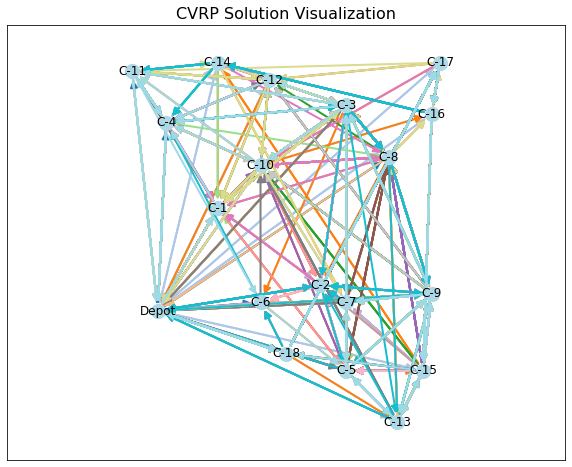

In [20]:
filename =  '../Instances/Adj-P-n19-k2.txt'# '../Instances/cmt1_50.txt'  
solve_cvrp_column_generation(filename, cvrplib=True)

#### Branch-and-price Halucination

In [6]:
import sys
import math
import numpy as np
import networkx as nx
import cplex
from cplex.exceptions import CplexError

def read_instance(filename):
    """
    Reads the CVRP instance from a file.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Remove any empty lines or lines with only whitespace
    lines = [line.strip() for line in lines if line.strip()]

    idx = 0
    num_customers, _ = map(float, lines[idx].split())
    num_customers = int(num_customers)
    idx += 1
    capacity = int(lines[idx])
    idx += 1
    depot_coords = tuple(map(int, lines[idx].split()))
    idx += 1

    customers = []
    for _ in range(num_customers):
        customer_info = lines[idx].split()
        idx += 1
        customer_number = int(customer_info[0])
        x = int(customer_info[1])
        y = int(customer_info[2])
        demand = int(customer_info[3])
        customers.append({
            'number': customer_number,
            'x': x,
            'y': y,
            'demand': demand
        })

    return capacity, depot_coords, customers

def compute_distance_matrix(coords):
    """
    Computes the Manhatan distance matrix between all pairs of coordinates.
    """
    num_nodes = len(coords)
    distance_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    for i in range(num_nodes):
        xi, yi = coords[i]
        for j in range(num_nodes):
            xj, yj = coords[j]
            distance = abs(xi - xj) + abs(yi - yj)
            distance_matrix[i][j] = int(distance)
    return distance_matrix

# Function to generate initial routes (e.g., one customer per route)
def generate_initial_routes(customers, depot_coords, capacity):
    """
    Generates initial feasible routes (one customer per route).
    """
    routes = []
    for customer in customers:
        if customer['demand'] <= capacity:
            route = [0, customer['number'], 0]  # 0 represents the depot
            routes.append(route)
    return routes

# Function to compute the cost of a route
def compute_route_cost(route, distance_matrix):
    cost = 0
    for i in range(len(route) - 1):
        cost += distance_matrix[route[i]][route[i+1]]
    return cost

# Function to solve the Restricted Master Problem
def solve_master_problem(routes, customers, num_customers, U, distance_matrix):
    """
    Solves the Restricted Master Problem (RMP).
    """
    try:
        prob = cplex.Cplex()
        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        # Objective: Minimize total cost
        obj = []
        names = []
        ub = []
        lb = []
        types = []

        for idx, route in enumerate(routes):
            cost = compute_route_cost(route, distance_matrix)
            obj.append(cost)
            names.append("theta_{}".format(idx))
            ub.append(cplex.infinity)
            lb.append(0.0)
            types.append(prob.variables.type.continuous)

        prob.variables.add(obj=obj, lb=lb, ub=ub, types=types, names=names)

        # Constraints: Each customer is visited at least once
        constraints = []
        rhs = []
        senses = []

        for customer in customers:
            indices = []
            coefs = []
            for idx, route in enumerate(routes):
                if customer['number'] in route:
                    indices.append("theta_{}".format(idx))
                    coefs.append(1)
            constraints.append([indices, coefs])
            rhs.append(1)
            senses.append("G")  # Greater than or equal

        # Constraint: Number of vehicles used does not exceed U
        indices = ["theta_{}".format(idx) for idx in range(len(routes))]
        coefs = [1.0] * len(routes)
        constraints.append([indices, coefs])
        rhs.append(U)
        senses.append("L")  # Less than or equal

        prob.linear_constraints.add(lin_expr=constraints, senses=senses, rhs=rhs)

        # Solve the problem
        prob.solve()

        # Get the solution
        theta_values = prob.solution.get_values()
        dual_values = prob.solution.get_dual_values()

        # Get dual variables corresponding to customer constraints
        duals_customers = dual_values[:num_customers]
        # Dual variable for the fleet size constraint
        dual_fleet_size = dual_values[-1]

        return prob.solution.get_objective_value(), theta_values, duals_customers, dual_fleet_size

    except CplexError as e:
        print("Cplex Error:", e)
        return None, None, None, None

# Function to solve the subproblem (ESPPRC)
def solve_subproblem(distance_matrix, duals_customers, dual_fleet_size, customers, capacity):
    """
    Solves the subproblem to find a route with negative reduced cost.
    """
    # Adjust arc costs with dual variables
    num_nodes = len(distance_matrix)
    adjusted_costs = np.copy(distance_matrix)
    for i in range(1, num_nodes):  # Skip depot at index 0
        adjusted_costs[0][i] -= dual_fleet_size
        adjusted_costs[i][0] -= duals_customers[i-1]
        for j in range(1, num_nodes):
            adjusted_costs[i][j] -= duals_customers[j-1]

    # Build graph for ESPPRC
    G = nx.DiGraph()
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                G.add_edge(i, j, cost=adjusted_costs[i][j], demand=customers[j-1]['demand'] if j != 0 else 0)

    # Implement labeling algorithm for ESPPRC
    # Since ESPPRC is NP-hard, we can approximate using shortest path without cycles
    # and capacity constraints.

    # Labels are tuples: (cost, demand, path)
    labels = {0: [(0, 0, [0])]}  # Start from depot
    queue = [0]

    best_route = None
    best_cost = float('inf')

    while queue:
        current = queue.pop(0)
        current_labels = labels[current]

        for successor in G.successors(current):
            arc = G[current][successor]
            for cost, demand, path in current_labels:
                new_demand = demand + arc['demand']
                if new_demand <= capacity and successor not in path:
                    new_cost = cost + arc['cost']
                    new_path = path + [successor]
                    if successor == 0 and new_cost < 0 and len(new_path) > 2:
                        # Found a negative reduced cost route
                        if new_cost < best_cost:
                            best_cost = new_cost
                            best_route = new_path
                    else:
                        if successor not in labels or all(label[0] > new_cost for label in labels.get(successor, [])):
                            labels.setdefault(successor, []).append((new_cost, new_demand, new_path))
                            queue.append(successor)

    return best_route, best_cost

# Main function
def gecol_with_bp(filename):
    # Read instance data
    capacity, depot_coords, customers = read_instance(filename)

    # Prepare data
    coords = [depot_coords] + [(c['x'], c['y']) for c in customers]
    distance_matrix = compute_distance_matrix(coords)
    num_customers = len(customers)
    U = len(customers)  # Initial upper bound on number of vehicles

    # Generate initial routes
    routes = generate_initial_routes(customers, depot_coords, capacity)

    iteration = 0
    while True:
        iteration += 1
        print(f"Iteration {iteration}")

        # Solve Master Problem
        obj_value, theta_values, duals_customers, dual_fleet_size = solve_master_problem(
            routes, customers, num_customers, U, distance_matrix
        )

        if obj_value is None:
            print("No feasible solution found.")
            break

        print(f"Objective Value: {obj_value}")

        # Solve Subproblem
        new_route, reduced_cost = solve_subproblem(
            distance_matrix, duals_customers, dual_fleet_size, customers, capacity
        )

        if new_route is None or reduced_cost >= -1e-6:
            # No negative reduced cost route found
            print("Optimal solution found.")
            break
        else:
            # Add new route to the route list
            routes.append(new_route)
            print(f"New route added with reduced cost {reduced_cost}: {new_route}")

    # TODO: Implement branching for integer solutions (Branch-and-Price)

    # Extract integer solution (for demonstration purposes)
    theta_int = [round(value) for value in theta_values]
    final_routes = [route for idx, route in enumerate(routes) if theta_int[idx] > 0]

    print("Final Routes:")
    for route in final_routes:
        print(route)


In [7]:
gecol_with_bp(filename='../Instances/simple.txt')

Iteration 1
Cplex Error: CPLEX Error  1017: Not available for mixed-integer problems.
No feasible solution found.


TypeError: 'NoneType' object is not iterable

# Column Generation from 0

## Modelo MIP

In [ ]:
def mip_model(filename, cvrplib:bool=False):
    """
    Solves the CVRP with Mixed Integer Programming solver.
    """

    # Read data
    capacity, depot_coords, customers = read_cvrplib_instance(filename) if cvrplib else read_instance(filename)
    
    num_customers = len(customers)
    num_nodes = num_customers + 1  # Including depot (node 0)
    customer_indices = list(range(1, num_nodes))
    node_indices = list(range(num_nodes))

    # Coordinates for depot and customers
    coords = [depot_coords] + [(c['x'], c['y']) for c in customers]
    demands = [0] + [c['demand'] for c in customers]
    distance_matrix = compute_distance_matrix(coords)

    model = cplex.Cplex()
    model.objective.set_sense(model.objective.sense.minimize)

    # Define decision variables:
    x = [[model.variables.add(obj=[distance_matrix[i][j] for j in range(num_customers)],
                            lb=[0] * num_customers, ub=[1  for j in range(i)]+[0]+[1 for j in range(i+1,num_customers)],
                            types=[model.variables.type.binary] * num_customers,
                            names=[f'x_{i}_{j}_{k}' for j in range(num_customers)]) for i in range(num_customers)] 
                            for k in range(num_customers)]
    
    # Para cada vértice sai um arco
    for k in range(num_customers):
        model.linear_constraints.add(
            lin_expr=[cplex.SparsePair([x[k][i][j] for j in range(num_customers) if i != j], [1.0] * (num_customers-1))
                    for i in range(num_customers)],
            senses=['E'] * num_customers,
            rhs=[1.0] * num_customers, names=['Sai_'+str(i) for i in range(num_customers)])

    # # Para cada vértice chega um arco
    # model.linear_constraints.add(
    #     lin_expr=[cplex.SparsePair([x[j][i] for j in range(num_customers) if i != j], [1.0] * (num_customers-1))
    #             for i in range(num_customers)],
    #     senses=['E'] * num_customers,
    #     rhs=[1.0] * num_customers, names=['Chega_'+str(i) for i in range(num_customers)])

    #x_ij variables for each possible route
    # x = []
    # for k in range(num_customers):
    #     x_k = {}
    #     for i in node_indices:
    #         for j in node_indices:
    #             x_k[(i,j)] = model.variables.add(
    #                 obj=[distance_matrix[i][j]],
    #                 lb=[0], ub=[1] if j != i else [0],
    #                 types=[model.variables.type.binary],
    #                 names=[f'x_{i}_{j}']
    #             )
    #     x.append(x_k)
    # print(len(x), len(x[0]), x[0][1], x[0][1][4])

    # # Constraints:
    # # 1. Flow conservation constraints for customers
    # for i in customer_indices:
    #     # Sum over arcs entering customer i
    #     in_vars = [x[k][(j, i)] for j in node_indices if j != i and (j, i) in x]
    #     coeffs = [1] * len(in_vars)
    #     cvrp.linear_constraints.add(
    #         lin_expr=[cplex.SparsePair(in_vars, coeffs)],
    #         senses=["E"],
    #         rhs=[1],
    #         names=[f"inflow_{i}"]
    #     )

    #     # Sum over arcs leaving customer i
    #     out_vars = [x_vars[(i, j)] for j in node_indices if j != i and (i, j) in x_vars]
    #     coeffs = [1] * len(out_vars)
    #     cvrp.linear_constraints.add(
    #         lin_expr=[cplex.SparsePair(out_vars, coeffs)],
    #         senses=["E"],
    #         rhs=[1],
    #         names=[f"outflow_{i}"]
    #     ) 
    

In [ ]:
def modelo():
    """Resolve o CVRP."""
	
    l = len(F)
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.maximize)
    x = cpx.variables.add(obj=[p[i] for i in range(n)],
                             lb=[0] * n, ub=[1] * n,
                             types=[cpx.variables.type.binary] * n,
                             names=['x_'+str(i) for i in range(n)])
    
    v = cpx.variables.add(obj=[-F[t] for t in F],
                             lb=[0] * l, ub=[1] * l,
                             types=[cpx.variables.type.continuous] * l,
                             names=['v_'+str(i)+"_"+str(j) for i,j in F])
 
    # Mochila
    cpx.linear_constraints.add(
        lin_expr=[cplex.SparsePair([x[i] for i in range(n)], [float(w[i]) for i in range(n)])],
        senses=['L'],
        rhs=[float(b)], names=['sac'])

    # Linearizacao
    cpx.linear_constraints.add(
        lin_expr=[cplex.SparsePair([x[i]]+[x[j]]+['v_'+str(i)+"_"+str(j)], [1.0,1.0,-1.0]) for i,j in F],
        senses=['L'] * l,
        rhs=[1.0] * l, names=['lin_'+str(i)+"_"+str(j) for i,j in F])
    # Tweak some CPLEX parameters so that CPLEX has a harder time to
    # solve the model and our cut separators can actually kick in.
    cpx.parameters.mip.strategy.heuristicfreq.set(-1)
    cpx.parameters.mip.strategy.presolvenode.set(-1)
    cpx.parameters.mip.cuts.mircut.set(-1)
    cpx.parameters.mip.cuts.implied.set(-1)
    cpx.parameters.mip.cuts.gomory.set(-1)
    cpx.parameters.mip.cuts.flowcovers.set(-1)
    cpx.parameters.mip.cuts.pathcut.set(-1)
    cpx.parameters.mip.cuts.liftproj.set(-1)
    cpx.parameters.mip.cuts.zerohalfcut.set(-1)
    cpx.parameters.mip.cuts.cliques.set(-1)
    cpx.parameters.mip.cuts.covers.set(-1)
    cpx.parameters.mip.limits.cutsfactor.set(0)
    cpx.parameters.mip.limits.eachcutlimit.set(0)
    cpx.parameters.mip.limits.cutpasses.set(-1)
    cpx.parameters.preprocessing.repeatpresolve.set(0)
    cpx.parameters.preprocessing.relax.set(0)
    cpx.parameters.preprocessing.boundstrength.set(0)
    cpx.parameters.preprocessing.symmetry.set(0)
    cpx.parameters.preprocessing.folding.set(0)
    cpx.parameters.preprocessing.aggregator.set(0)
    cpx.parameters.preprocessing.coeffreduce.set(0)
    cpx.parameters.preprocessing.dependency.set(0)
    cpx.parameters.preprocessing.dual.set(-1)
    cpx.parameters.preprocessing.presolve.set(0)
    cpx.parameters.preprocessing.numpass.set(0)
    cpx.parameters.threads.set(1)
    cpx.parameters.clocktype.set(1)
    cpx.parameters.timelimit.set(600)

    
    cpx.write("KPF.lp")
    
    cpx.solve()

    print('Solution status:                   %d' % cpx.solution.get_status())
    print('Nodes processed:                   %d' %
          cpx.solution.progress.get_num_nodes_processed())
    tol = cpx.parameters.mip.tolerances.integrality.get()
    print('Optimal value:                     %f' %
          cpx.solution.get_objective_value())
    values = cpx.solution.get_values()
    for i in range(n):
    		if values[x[i]] >= 1 - tol:
    			print("x_"+str(i)+"= "+str(values[x[i]]))

In [64]:
filename = '../Instances/simple.txt'
mip_model(filename=filename)

10 10 range(10, 20) 14


## Java based solution

### Translation

In [30]:
import sys
import math
from cplex import Cplex
import cplex
from cplex.exceptions import CplexError
import time

# Assuming we have necessary imports for data handling
# For the database connection, we'll simulate data loading

class ColumnGen:
    def __init__(self, instance, cvrplib:bool=True):
        self.instance = instance
        self.cvrplib = cvrplib # Instance file format
        self.depot_start = None
        self.depot_end = None
        self.capacity = None
        self.all_customers = {}
        self.all_nodes = {}
        self.paths = []
        # self.distance_matrix = None
        self.masterproblem = None
        self.subproblem = None
        self.logger = Logger()
        self.ReadData()
        self.masterproblem = self.MasterProblem(self)
        self.subproblem = self.SubProblem(self)

    class Node:
        def __init__(self, external_id, x, y, parent):
            self.parent = parent  # Reference to ColumnGen instance
            self.id = len(self.parent.all_nodes)
            self.id_external = external_id
            self.xcoord = x
            self.ycoord = y
            self.parent.all_nodes[self.id] = self

        def dist_to_node(self, node_to):
            # return self.parent.distance_matrix[self.id_external][node_to.id_external] 
            return math.hypot(self.xcoord - node_to.xcoord, self.ycoord - node_to.ycoord)
    
    class Depot(Node):
        def __init__(self, external_id, x, y, parent):
            super().__init__(external_id, x, y, parent)

    class Customer(Node):
        def __init__(self, external_id, x, y, demand, parent):
            super().__init__(external_id, x, y, parent)
            self.demand = demand
            self.parent.all_customers[self.id] = self

        def d(self):
            return self.demand

    class Path:
        def __init__(self, stops_new_path, parent):
            self.parent = parent  # Reference to ColumnGen instance
            self.customers = []
            # From first customer in path to last customer prior to depot
            for i in range(1, len(stops_new_path) - 1):
                self.customers.append(self.parent.all_customers[stops_new_path[i]])
            self.cost = self.calculateCost()
            self.id = len(self.parent.paths)
            self.y = None  # Variable in master problem
            self.parent.paths.append(self)

        def calculateCost(self):
            if len(self.customers) > 0:
                cost = self.parent.depot_start.dist_to_node(self.customers[0])
                for i in range(1, len(self.customers)):
                    cost += self.customers[i - 1].dist_to_node(self.customers[i])
                cost += self.customers[-1].dist_to_node(self.parent.depot_end)
            else:
                cost = 0
            return cost

        def a(self, customer):
            return 1 if customer in self.customers else 0

        def displayInfo(self):
            print(f"Path id : {self.id}")
            stops = '->'.join([str(c.id_external) for c in self.customers])
            print(f"Stops : depot->{stops}->depot")
            print(f"Cost : {self.cost}")

    class MasterProblem:
        def __init__(self, parent):
            self.parent = parent  # Reference to ColumnGen instance
            self.cplex = None
            self.total_cost = None
            self.row_customers = {}
            self.pi = {}
            self.mipConversion = []
            self.lastObjValue = None
            self.createModel()
            self.createDefaultPaths()
            # Parameters.configureCplex(self)  # Configure CPLEX parameters if needed

        def createDefaultPaths(self):
            for c in self.parent.all_customers.values():
                new_path = [self.parent.depot_start.id, c.id, self.parent.depot_end.id]
                self.addNewColumn(self.parent.Path(new_path, self.parent))

        def createModel(self): 
            try:
                self.cplex = Cplex()
                self.cplex.objective.set_sense(self.cplex.objective.sense.minimize)
                self.total_cost = []
                # Add constraints for each customer
                for customer in self.parent.all_customers.values():
                    name = f"cust_{customer.id}"
                    # constraint = [[[]], [[]]] #FIXME?
                    # Initially, no variables are associated with the constraint
                    # We'll add coefficients when adding columns (paths)
                    self.cplex.linear_constraints.add(
                        lin_expr=[cplex.SparsePair([], [])],
                        senses=["E"],
                        rhs=[1],
                        names=[name]
                    )
                    self.row_customers[customer] = name
                    # self.cplex.linear_constraints.add(lin_expr=constraint, senses="E", rhs=[1], names=[name])
            except CplexError as e:
                print("Cplex exception caught:", e)

        def addNewColumn(self, path):
            try:
                num_paths = len(self.parent.paths)
                var_name = f"y_{path.id}"
                path.y = var_name
                self.cplex.variables.add(obj=[path.cost], lb=[0], ub=[1], types=["C"], names=[var_name])
                # Add coefficients to customer constraints
                for customer in self.parent.all_customers.values():
                    coef = path.a(customer)
                    if coef != 0:
                        row_index = list(self.cplex.linear_constraints.get_names()).index(self.row_customers[customer])
                        col_index = self.cplex.variables.get_names().index(var_name)
                        self.cplex.linear_constraints.set_coefficients(row_index, col_index, coef)
            except CplexError as e:
                print("Cplex exception caught:", e)

        def solveRelaxation(self):
            try:
                self.cplex.set_problem_type(self.cplex.problem_type.LP)
                self.cplex.solve()
                self.saveDualValues()
                self.lastObjValue = self.cplex.solution.get_objective_value()
            except CplexError as e:
                print("Cplex exception caught:", e)

        def saveDualValues(self):
            try:
                duals = self.cplex.solution.get_dual_values()
                constraint_names = self.cplex.linear_constraints.get_names()
                for customer in self.parent.all_customers.values():
                    idx = constraint_names.index(self.row_customers[customer])
                    self.pi[customer] = duals[idx]
            except CplexError as e:
                print("Cplex exception caught:", e)

        def convertToMIP(self):
            try:
                var_names = [path.y for path in self.parent.paths]
                indices = [self.cplex.variables.get_names().index(name) for name in var_names]
                self.cplex.variables.set_types(zip(indices, ['B'] * len(indices)))
            except CplexError as e:
                print("Cplex exception caught:", e)

        def solveMIP(self):
            try:
                self.convertToMIP()
                self.cplex.set_problem_type(self.cplex.problem_type.MILP)
                self.cplex.solve()
                if self.cplex.solution.get_status() == self.cplex.solution.status.optimal:
                    self.displaySolution()
                    # self.logger.writeLog(self.parent.instance, self.cplex.solution.get_objective_value(), self.cplex.solution.MIP.get_best_objective())
                else:
                    print("Integer solution not found")
            except CplexError as e:
                print("Cplex exception caught:", e)

        def displaySolution(self):
            try:
                for path in self.parent.paths:
                    idx = self.cplex.variables.get_names().index(path.y)
                    value = self.cplex.solution.get_values(idx)
                    if value > 0.99999:
                        path.displayInfo()
            except CplexError as e:
                print("Cplex exception caught:", e)

    class SubProblem:
        def __init__(self, parent):
            self.parent = parent  # Reference to ColumnGen instance
            self.cplex = None
            self.x = {}
            self.u = {}  # Continuous variables for cumulative load at customers
            self.reduced_cost = None
            self.constraints = []
            self.lastObjValue = None
            self.lastObjValueRelaxed = None
            self.createModel()
            # self.setPriority()  # Set variable priorities if needed
            # Parameters.configureCplex(self)
            # self.mip_call_back = self.MyMipCallBack()

        def createModel(self):
            try:
                self.cplex = Cplex()
                self.cplex.objective.set_sense(self.cplex.objective.sense.minimize)

                # Variables
                nodes = self.parent.all_nodes
                num_nodes = len(nodes)
                all_customers = self.parent.all_customers

                Q = self.parent.capacity  # Vehicle capacity
                q = {i: all_customers[i].d() for i in all_customers}  # Customer demands

                self.x = {}
                for i in nodes:
                    for j in nodes:
                        if i != j:
                            var_name = f"x_{i}_{j}"
                            self.x[(i, j)] = var_name
                self.cplex.variables.add(names=list(self.x.values()), types=["B"] * len(self.x))
                
                # Variables: u[i] - continuous variables representing cumulative load at customer i
                # Defined for customers only (excluding depot)
                for i in all_customers:
                    var_name = f"u_{i}"
                    self.u[i] = var_name
                self.cplex.variables.add(
                    names=list(self.u.values()),
                    lb=[q[i] for i in self.u],  # Lower bound: demand at customer i
                    ub=[Q] * len(self.u),       # Upper bound: vehicle capacity
                    types=["C"] * len(self.u)
                )

                # Constraints

                # 1. Capacity Constraint
                # sum over i in customers, sum over j, demand[i] * x[i,j] <= vehicle capacity
                capacity_expr = []
                capacity_coef = []
                for i in all_customers:
                    for j in nodes:
                        if (i, j) in self.x:
                            capacity_expr.append(self.x[(i, j)])
                            capacity_coef.append(all_customers[i].d())
                self.cplex.linear_constraints.add(
                    lin_expr=[cplex.SparsePair(capacity_expr, capacity_coef)],
                    senses=["L"],
                    rhs=[self.parent.capacity],
                    names=["Capacity"]
                )

                # 2. Start from Depot Constraint
                depot_start_id = self.parent.depot_start.id
                start_expr = []
                for j in nodes:
                    if depot_start_id != j and (depot_start_id, j) in self.x:
                        start_expr.append(self.x[(depot_start_id, j)])
                self.cplex.linear_constraints.add(
                    lin_expr=[cplex.SparsePair(start_expr, [1]*len(start_expr))],
                    senses=["E"],
                    rhs=[1],
                    names=["StartDepot"]
                )

                # 3. Flow Conservation Constraints
                # For each customer h, sum over i x[i,h] - sum over j x[h,j] == 0
                for h in all_customers:
                    flow_in = []
                    flow_out = []
                    for i in nodes:
                        if (i, h) in self.x:
                            flow_in.append(self.x[(i, h)])
                    for j in nodes:
                        if (h, j) in self.x:
                            flow_out.append(self.x[(h, j)])
                    expr_vars = flow_in + flow_out
                    expr_coefs = [1]*len(flow_in) + [-1]*len(flow_out)
                    self.cplex.linear_constraints.add(
                        lin_expr=[cplex.SparsePair(expr_vars, expr_coefs)],
                        senses=["E"],
                        rhs=[0],
                        names=[f"Flow_{h}"]
                    )

                # 4. End at Depot Constraint
                depot_end_id = self.parent.depot_end.id
                end_expr = []
                for i in nodes:
                    if i != depot_end_id and (i, depot_end_id) in self.x:
                        end_expr.append(self.x[(i, depot_end_id)])
                self.cplex.linear_constraints.add(
                    lin_expr=[cplex.SparsePair(end_expr, [1]*len(end_expr))],
                    senses=["E"],
                    rhs=[1],
                    names=["EndDepot"]
                )

                # 5. Subtour Elimination Constraints (MTZ Constraints)
                # u[i] - u[j] + Q * x[i,j] <= Q - q[j], for all i != j, i, j != depot
                for i in all_customers:
                    for j in all_customers:
                        if i != j and (i, j) in self.x:
                            expr_vars = [self.u[i], self.u[j], self.x[(i, j)]]
                            expr_coefs = [1, -1, Q]
                            rhs = Q - q[j]
                            self.cplex.linear_constraints.add(
                                lin_expr=[cplex.SparsePair(expr_vars, expr_coefs)],
                                senses=["L"],
                                rhs=[rhs],
                                names=[f"SubtourEl_{i}_{j}"]
                            )

                # Additional constraints to link u[i] with the depot arcs
                # For arcs from depot to customers
                for j in all_customers:
                    if (depot_start_id, j) in self.x:
                        # u[j] >= q[j] * x[depot, j]
                        expr_vars = [self.u[j], self.x[(depot_start_id, j)]]
                        expr_coefs = [1, -q[j]]
                        self.cplex.linear_constraints.add(
                            lin_expr=[cplex.SparsePair(expr_vars, expr_coefs)],
                            senses=["G"],
                            rhs=[0],
                            names=[f"LoadFromDepot_{j}"]
                        )
                
                # 6. Prohibited Moves Constraints 
                prohibited_expr = []
                for i in nodes:
                    # No arcs from depot_end to any node
                    if (depot_end_id, i) in self.x:
                        prohibited_expr.append(self.x[(depot_end_id, i)])
                    # No arcs to depot_start from any node
                    if (i, depot_start_id) in self.x:
                        prohibited_expr.append(self.x[(i, depot_start_id)])
                    # No loops (x[i,i] = 0)
                    if (i, i) in self.x:
                        prohibited_expr.append(self.x[(i, i)])
                self.cplex.linear_constraints.add(
                    lin_expr=[cplex.SparsePair(prohibited_expr, [1]*len(prohibited_expr))],
                    senses=["E"],
                    rhs=[0],
                    names=["ProhibitedMoves"]
                )

                # Initialize the objective function (will be updated later)
                # self.cplex.objective.set_linear([(self.x[arc], 0) for arc in self.x])

            except CplexError as e:
                print("Cplex exception caught:", e)

        def updateReducedCost(self):
            try:
                # Objective function
                obj = []
                obj_names = []
                for (i, j) in self.x:
                    t_ij = self.parent.all_nodes[i].dist_to_node(self.parent.all_nodes[j])
                    if i in self.parent.all_customers:
                        pi_i = self.parent.masterproblem.pi[self.parent.all_customers[i]]
                        cost = t_ij - pi_i
                    else:
                        cost = t_ij
                    obj.append(cost)
                    obj_names.append(self.x[(i, j)])
                self.cplex.objective.set_linear(zip(obj_names, obj))
                self.cplex.objective.set_sense(self.cplex.objective.sense.minimize)
                # Constraints can be added similarly
            except CplexError as e:
                print("Cplex exception caught:", e)

        def solve(self):
            try:
                self.cplex.solve()
                self.lastObjValue = self.cplex.solution.get_objective_value()
                self.lastObjValueRelaxed = self.cplex.solution.MIP.get_best_objective()
                # Check if reduced cost is negative
                if self.lastObjValue < -1e-6:
                    self.savePath()
            except CplexError as e:
                print("Cplex exception caught:", e)

        def savePath(self):
            try:
                # Extract solution values
                x_values = self.cplex.solution.get_values(list(self.x.values()))
                x_vars = list(self.x.keys())
                x_dict = {x_vars[i]: x_values[i] for i in range(len(x_vars))}

                # Reconstruct the path from x_values
                # Start from the depot_start
                current_node = self.parent.depot_start.id
                path_nodes = [current_node]
                while current_node != self.parent.depot_end.id:
                    for (i, j) in self.x:
                        if i == current_node and x_dict.get((i, j), 0) > 0.5:
                            path_nodes.append(j)
                            current_node = j
                            break
                    else:
                        # No further node found, break to prevent infinite loop
                        break

                # Create a new Path object if the path is valid
                if path_nodes[-1] == self.parent.depot_end.id and len(path_nodes) > 2:
                    new_path = self.parent.Path(path_nodes, self.parent)
                    # Add the new path to the master problem
                    self.parent.masterproblem.addNewColumn(new_path)
                else:
                    print("No valid path found in subproblem solution.")
            except CplexError as e:
                print("Cplex exception caught in savePath():", e)

    def ReadData(self):

        # Method for reading standard cvrplib instances
        def read_cvrplib_instance(file_path):
            """
            Reads a CVRP instance from a CVRPLIB file and returns the node coordinates, demands, and capacity.
            """
            customers = []
            depot_coords = tuple()
            capacity = 0
            with open(file_path, 'r') as file:
                section = None
                for line in file:
                    line = line.strip()
                    if line.startswith('CAPACITY'):
                        capacity = int(line.split(':')[1].strip())
                    elif line.startswith('NODE_COORD_SECTION'):
                        section = 'NODE_COORD_SECTION'
                    elif line.startswith('DEMAND_SECTION'):
                        section = 'DEMAND_SECTION'
                    elif line.startswith('DEPOT_SECTION'):
                        break
                    elif section == 'NODE_COORD_SECTION' and line != '':
                        parts = line.split()

                        node_id = int(parts[0])
                        x_coord = int(parts[1])
                        y_coord = int(parts[2])

                        if node_id == 0:
                            depot_coords = (x_coord, y_coord)
                        else:
                            customers.append({
                                'number': node_id,
                                'x': x_coord,
                                'y': y_coord,
                                'demand': 0
                            })
                            # print(customers)
                    elif section == 'DEMAND_SECTION' and line != '':
                        parts = line.split()

                        node_id = int(parts[0])
                        demand = float(parts[1])

                        if node_id != 0:
                            customers[node_id-1]['demand'] = demand
            return capacity, depot_coords, customers

        # Method for reading non cvrplib instances
        def read_instance(file_path):
            """
            Reads the CVRP instance from a file.

            The file format is assumed to be:
            - The first line contains two numbers: number of customers and best known solution (ignored).
            - The second line contains the vehicle capacity.
            - The third line contains the depot coordinates (x y).
            - The following lines contain customer data: customer number, x, y, demand.

            Returns:
            - capacity: Vehicle capacity.
            - depot_coords: Coordinates of the depot (tuple).
            - customers: List of customer dictionaries with keys 'number', 'x', 'y', 'demand'.
            """
            with open(file_path, 'r') as f:
                lines = f.readlines()

            # Remove any empty lines or lines with only whitespace
            lines = [line.strip() for line in lines if line.strip()]

            idx = 0
            num_customers, _ = map(float, lines[idx].split())
            num_customers = int(num_customers)
            idx += 1
            capacity = int(lines[idx])
            idx += 1
            depot_coords = tuple(map(int, lines[idx].split()))
            idx += 1

            customers = []
            for _ in range(num_customers):
                customer_info = lines[idx].split()
                idx += 1
                customer_number = int(customer_info[0])
                x = int(customer_info[1])
                y = int(customer_info[2])
                demand = int(customer_info[3])
                customers.append({
                    'number': customer_number,
                    'x': x,
                    'y': y,
                    'demand': demand
                })

            return capacity, depot_coords, customers

        filepath = f"../Instances/{self.instance}.txt"
        if self.cvrplib:
            capacity, depot_coords, customers = read_cvrplib_instance(filepath)
        else:
            capacity, depot_coords, customers = read_instance(filepath)

        self.capacity = capacity
        self.depot_start = self.Depot(
            0, depot_coords[0], depot_coords[1], self
        )
        self.depot_end = self.Depot(
            0, depot_coords[0], depot_coords[1], self
        )

        # Add customers
        for c in customers:
            external_id = c['number']
            x = c['x']
            y = c['y']
            demand = c['demand']
            self.Customer(external_id, x, y, demand, self)

    def runColumnGeneration(self):
        iteration_counter = 0
        while True:
            iteration_counter += 1
            self.masterproblem.solveRelaxation()
            self.subproblem.updateReducedCost()
            self.subproblem.solve()
            self.displayIteration(iteration_counter)
            if self.subproblem.lastObjValue >= -1e-6:
                break
        self.masterproblem.solveMIP()

    def displayIteration(self, iter):
        if iter % 20 == 0 or iter == 1:
            print()
            print(f"{'Iteration':>9} {'Time':>9} {'nPaths':>9} {'MP lb':>12} {'SP lb':>12} {'SP int':>12}")
        print(f"{iter:9d} {time.time() / 60:9.1f} {len(self.paths):9d} {self.masterproblem.lastObjValue:12.4f} {self.subproblem.lastObjValueRelaxed:12.4f} {self.subproblem.lastObjValue:12.4f}")

class Logger:
    def timeStamp(self):
        return time.time()

# Assuming Parameters is a class or module containing configuration settings
class Parameters:
    capacity = 100.0
    infinity = 1e20
    ColGen = type('ColGen', (), {'subproblemObjVal': -1e-6, 'zero_reduced_cost': -1e-6, 'zero_reduced_cost_AbortColGen': -1e-6})


In [ ]:
if __name__ == '__main__':
    instance_name = 'simple' #'Adj-P-n19-k2'
    colgen = ColumnGen(instance_name, cvrplib=False)  
    colgen.runColumnGeneration()

CPLEX Error  1222: Duplicate entry or entries.


Cplex exception caught: CPLEX Error  1222: Duplicate entry or entries.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 10 rows and 10 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 41 rows and 25 columns.
MIP Presolve added 14 rows and 0 columns.
Reduced MIP has 86 rows, 117 columns, and 485 nonzeros.
Reduced MIP has 107 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.53 ticks)
Probing time = 0.00 sec. (0.38 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 86 rows, 117 columns, and 485 nonzeros.
Reduced MIP has 107 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 se

In [17]:
x = {}
for i in range(3):
    for j in range(3):
        x[(i,j)] = f'x_{i}_{j}'

obj = []
cost = 0
obj_names = []
for (i, j) in x:
    cost += 1
    obj.append(cost)
    obj_names.append(x[(i,j)])

for i in zip(obj_names, obj):
    print(i)

('x_0_0', 1)
('x_0_1', 2)
('x_0_2', 3)
('x_1_0', 4)
('x_1_1', 5)
('x_1_2', 6)
('x_2_0', 7)
('x_2_1', 8)
('x_2_2', 9)


### Handcrafted

#### Classe Definitions

In [ ]:
class Node:
    def __init__(self, external_id, x, y, parent):
        self.parent = parent  # Reference to ColumnGen instance
        self.id = len(self.parent.all_nodes)
        self.id_external = external_id
        self.xcoord = x
        self.ycoord = y
        self.parent.all_nodes[self.id] = self

    def dist_to_node(self, node_to):
        return math.hypot(self.xcoord - node_to.xcoord, self.ycoord - node_to.ycoord)

In [ ]:
class Depot(Node):
    def __init__(self, external_id, x, y, parent):
        super().__init__(external_id, x, y, parent)

In [ ]:
class Customer(Node):
    def __init__(self, external_id, x, y, demand, parent):
        super().__init__(external_id, x, y, parent)
        self.demand = demand
        self.parent.all_customers[self.id] = self

    def d(self):
        return self.demand

In [ ]:
class Path:
    def __init__(self, stops_new_path, parent):
        self.parent = parent  # Reference to ColumnGen instance
        self.customers = []
        # From first customer in path to last customer prior to depot
        for i in range(1, len(stops_new_path) - 1):
            self.customers.append(self.parent.all_customers[stops_new_path[i]])
        self.cost = self.calculateCost()
        self.id = len(self.parent.paths)
        self.y = None  # Variable in master problem
        self.parent.paths.append(self)

    def calculateCost(self):
        if len(self.customers) > 0:
            cost = self.parent.depot_start.dist_to_node(self.customers[0])
            for i in range(1, len(self.customers)):
                cost += self.customers[i - 1].dist_to_node(self.customers[i])
            cost += self.customers[-1].dist_to_node(self.parent.depot_end)
        else:
            cost = 0
        return cost

    def a(self, customer):
        return 1 if customer in self.customers else 0

    def displayInfo(self):
        print(f"Path id : {self.id}")
        stops = '->'.join([str(c.id_external) for c in self.customers])
        print(f"Stops : depot->{stops}->depot")
        print(f"Cost : {self.cost}")

In [ ]:
class ColumnGen:
    def __init__(self, instance):
        self.instance = instance
        self.depot_start = None
        self.depot_end = None
        self.all_customers = {}
        self.all_nodes = {}
        self.paths = []
        self.masterproblem = None
        self.subproblem = None
        self.logger = Logger()
        self.ReadData()
        self.masterproblem = self.MasterProblem(self)
        self.subproblem = self.SubProblem(self)